In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import preprocessing
from imblearn.over_sampling import SMOTE
from sklearn.metrics import f1_score,accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler

import warnings
sns.set()
warnings.filterwarnings('ignore')

# Data
https://www.kaggle.com/competitions/higgs-boson/data

In [ ]:
training = '/content/training.csv'
testing = '/content/test.csv'
random_sub = '/content/random_submission.csv'
train = pd.read_csv(training)
test = pd.read_csv(testing)
random = pd.read_csv(random_sub)

In [ ]:
train.head()

,EventId,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,...,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt,Weight,Label
0,100000,138.470,51.655,97.827,27.980,0.91,124.711,2.666,3.064,41.928,...,2,67.435,2.150,0.444,46.062,1.24,-2.475,113.497,0.002653,s
1,100001,160.937,68.768,103.235,48.146,-999.00,-999.000,-999.000,3.473,2.078,...,1,46.226,0.725,1.158,-999.000,-999.00,-999.000,46.226,2.233584,b
2,100002,-999.000,162.172,125.953,35.635,-999.00,-999.000,-999.000,3.148,9.336,...,1,44.251,2.053,-2.028,-999.000,-999.00,-999.000,44.251,2.347389,b
3,100003,143.905,81.417,80.943,0.414,-999.00,-999.000,-999.000,3.310,0.414,...,0,-999.000,-999.000,-999.000,-999.000,-999.00,-999.000,-0.000,5.446378,b
4,100004,175.864,16.915,134.805,16.405,-999.00,-999.000,-999.000,3.891,16.405,...,0,-999.000,-999.000,-999.000,-999.000,-999.00,-999.000,0.000,6.245333,b


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250000 entries, 0 to 249999
Data columns (total 33 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   EventId                      250000 non-null  int64  
 1   DER_mass_MMC                 250000 non-null  float64
 2   DER_mass_transverse_met_lep  250000 non-null  float64
 3   DER_mass_vis                 250000 non-null  float64
 4   DER_pt_h                     250000 non-null  float64
 5   DER_deltaeta_jet_jet         250000 non-null  float64
 6   DER_mass_jet_jet             250000 non-null  float64
 7   DER_prodeta_jet_jet          250000 non-null  float64
 8   DER_deltar_tau_lep           250000 non-null  float64
 9   DER_pt_tot                   250000 non-null  float64
 10  DER_sum_pt                   250000 non-null  float64
 11  DER_pt_ratio_lep_tau         250000 non-null  float64
 12  DER_met_phi_centrality       250000 non-null  float64
 13 

Weight ve Label colonunu çıkartıyoruz

In [ ]:
X_training = train.drop(['Weight','Label'], axis = "columns")

EventId sütununu 'X_training' veri kümesinin indeksi olarak ayarlıyoruz

In [ ]:
X_training.set_index("EventId", inplace = True)

'LabelEncoder' sınıfı, 'train1' veri kümesindeki hedef değişkeni 'Label' sütununu sayısal olarak kodlayarak, makine öğrenimi modelinin eğitimi için kullanılabilecek şekilde yeni bir veri kümesi oluşturur.

In [ ]:
label_encoder = preprocessing.LabelEncoder()
train1 = train['Label']

'LabelEncoder' sınıfının 'fit_transform' yöntemini kullanarak 'train1' veri kümesindeki etiket değerlerini sayısal olarak kodlar ve bu yeni kodlanmış etiketleri 'y_training' adlı değişkene atar.

In [ ]:
y_training = label_encoder.fit_transform(train1)

## Correlation matrix hesaplama

'corr' fonksiyonu ile 'X_training' veri kümesindeki tüm bağımsız değişkenler arasındaki Pearson korelasyon katsayılarını hesaplar ve sonuç olarak bir korelasyon matrisi oluşturur.

In [ ]:
corr_matrix = X_training.corr()

Korelasyon matrisindeki sütun sayısından 1 çıkararak bir döngü aralığı belirler.



In [ ]:
iters = range(len(corr_matrix.columns) - 1)

Yüksek korelasyona sahip değişkenleri tespit etmek için kullanılır. Döngü, korelasyon matrisindeki her bir sütununun diğer sütunlarıyla karşılaştırılmasını sağlar. Eğer bir sütun ile diğer sütun arasındaki korelasyon katsayısı, belirli bir 'threshold' değerinden büyükse, o sütun 'drop_cols' listesine eklenir.

In [ ]:
drop_cols = []

Belirli bir 'threshold' değerinin (0.9) belirlenmesiyle ilgilidir. Bu değer, yüksek korelasyona sahip değişkenlerin ne kadarının tespit edileceğini belirler.

In [ ]:
threshold = 0.9

## Korelasyon matrisi üzerinde döngü yaparak korelasyonları karşılaştırma

In [ ]:
for i in iters:
  for j in range(i+1):
    item = corr_matrix.iloc[j:(j+1), (i+1):(i+2)]
    col = item.columns
    row = item.index
    val = abs(item.values)
# Eğer korelasyon değeri, belirlenen eşik değerini aşarsa
    if val >= threshold:
      drop_cols.append(col.values[0])

# Korelasyonlu sütunların her birinden bir tanesini çıkar
drops = set(drop_cols)
X_training_dropped = X_training.drop(columns=drops)

print(f'Kaldırılan kolonlar : {drops}')

Kaldırılan kolonlar : {'PRI_jet_leading_eta', 'PRI_jet_subleading_eta', 'PRI_jet_subleading_phi', 'PRI_met_sumet', 'PRI_jet_subleading_pt', 'DER_mass_jet_jet', 'PRI_jet_leading_phi', 'DER_lep_eta_centrality', 'PRI_jet_all_pt', 'DER_prodeta_jet_jet'}


Bu kod, "X_training_dropped" adlı bir veri kümesinin çarpıklık (skewness) ölçülerini hesaplayarak "X_skew" adlı yeni bir veri kümesi oluşturur. "skewness", bir değişkenin dağılımının simetrik olmama derecesini ifade eder.


In [ ]:
X_skew = X_training_dropped.skew()

StandardScaler()" sınıfı kullanılarak, veri kümesindeki özellikler ölçeklendirilir. "X_training_dropped" veri kümesindeki özellikler "fit_transform()" yöntemi ile ölçeklendirilerek, ölçeklendirilmiş özellikler "robust_df" adlı yeni bir veri kümesinde saklanır. Daha sonra "pd.DataFrame()" fonksiyonu kullanılarak, ölçeklendirilmiş özelliklerin bulunduğu "robust_df" veri kümesi, "X_training_dropped" veri kümesinin sütun isimleri ile aynı isimlere sahip sütunlara sahip olarak yeniden düzenlenir. Bu işlem sonucunda, veri kümesindeki tüm özelliklerin aynı ölçeklendirme yöntemi ile ölçeklendirilmesi sağlanır.

In [ ]:
scaler = StandardScaler()
robust_df = scaler.fit_transform(X_training_dropped)
robust_df = pd.DataFrame(robust_df, columns = X_training_dropped.columns)

In [ ]:
X_training_skewed = robust_df

"x_temp" ve "y_temp" değişkenleri "X_training_skewed" ve "y_training" değişkenlerinin değerlerini alır. Daha sonra, "replace()" yöntemi kullanılarak "x_temp" değişkenindeki "np.inf", "-np.inf" ve "np.nan" değerleri sıfıra dönüştürülür. Bu işlem, veri kümesindeki sonsuz ve eksik değerlerin çıkarılması için yapılır ve sonuç olarak, temizlenmiş bir veri kümesi elde edilir.



In [ ]:
x_temp = X_training_skewed
y_temp = y_training
x_temp = x_temp.replace((np.inf, -np.inf, np.nan), 0)

Öncelikle, "SMOTE()" sınıfı kullanarak veri kümesindeki azınlık sınıfının örneklerinin sayısını artırırız. Bu, azınlık sınıfındaki örnek sayısı az olan veri kümelerinde dengesizliği gidermek için kullanılan bir tekniktir. "smt.fit_resample(x_temp,y_temp)" işlemi ile bu işlem gerçekleştirilir ve sonuçlar "X_temp_smooth" ve "y_temp_smooth" değişkenlerinde saklanır.

Daha sonra, "X_training_balanced" ve "y_training_balanced" adlı yeni veri kümeleri, önceden oluşturulan "X_temp_smooth" ve "y_temp_smooth" veri kümelerinin sütun isimleri ile aynı isimlere sahip sütunlara sahip olarak oluşturulur. Bu adım, dengelenmiş veri kümesindeki tüm özelliklerin orijinal veri kümesindeki özelliklere sahip olmasını sağlar.

In [ ]:
smt = SMOTE()

X_temp_smooth, y_temp_smooth = smt.fit_resample(x_temp,y_temp)

X_training_balanced = pd.DataFrame(X_temp_smooth, columns=x_temp.columns)
y_training_balanced = pd.DataFrame(y_temp_smooth, columns = ['Label'])

Accuracy Score, F1 Score, ROC AUC Score hesaplamak icin gerekli importlar

In [ ]:
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

train test split yapabilmek icin  gerekli olan import


In [ ]:
from sklearn.model_selection import train_test_split

Veri kümesi örneklerini eğitim ve doğrulama alt kümelerine bölmek için "train_test_split()" yöntemi kullanılır. Eğitim alt kümesi, veri kümesinin %80'ini ve doğrulama alt kümesi, veri kümesinin %20'sini oluşturur. "LogisticRegression()" sınıfı kullanılarak bir lojistik regresyon modeli oluşturulur ve "fit()" yöntemi kullanılarak eğitilir. Daha sonra, oluşturulan model, doğrulama alt kümesindeki özellikler kullanılarak tahminler yapmak için "predict()" yöntemi ile kullanılır ve bu tahminler "y_pred" değişkeninde saklanır.

Doğrulama kümesi üzerinde modelin performansını değerlendirir. Daha sonra, doğruluk, F1 skoru ve ROC AUC puanı ölçümlerini hesaplar ve ekrana yazdırır.

In [ ]:
X_train, X_test, y_train, y_test= train_test_split(X_training_balanced,
                                                 y_training_balanced,
                                                 train_size=0.8,
                                                 random_state=0)

### LogisticRegression

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
# Train
logistic_regression = LogisticRegression()
logistic_regression.fit(X_train, y_train)

# Predict the target values for the test data
y_prediction = logistic_regression.predict(X_test)

In [ ]:
log_acc=accuracy_score(y_test, y_prediction)
log_f1=f1_score(y_test, y_prediction)
log_roc_auc=roc_auc_score(y_test, y_prediction)
print(f'''Logistic Regression Model Evaluation Metrics:
- Accuracy: {(log_acc * 100):.2f}%
- F1 Score: {(log_f1 * 100):.2f}%
- ROC AUC Score: {(log_roc_auc * 100):.2f}%
''')

Logistic Regression Model Evaluation Metrics:
- Accuracy: 74.37%
- F1 Score: 75.25%
- ROC AUC Score: 74.37%



### RandomForestClassifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
# Train
random_forest = RandomForestClassifier()
random_forest.fit(X_train, y_train)

# Predict the target values for the test data
y_prediction_rf = random_forest.predict(X_test)

In [ ]:
rfc_acc=accuracy_score(y_test, y_prediction_rf)
rfc_f1=f1_score(y_test, y_prediction_rf)
rfc_roc_auc=roc_auc_score(y_test, y_prediction_rf)
print(f'''Random Forest Classifier Model Evaluation Metrics:
- Accuracy: {(rfc_acc * 100):.2f}%
- F1 Score: {(rfc_f1 * 100):.2f}%
- ROC AUC Score: {(rfc_roc_auc * 100):.2f}%
''')

Random Forest Classifier Model Evaluation Metrics:
- Accuracy: 85.95%
- F1 Score: 86.11%
- ROC AUC Score: 85.95%



### KNeighborsClassifier

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

Max Train Score : %100.0 - K : [1]
Max Test Score : %84.212127666048 - Best K : [1]


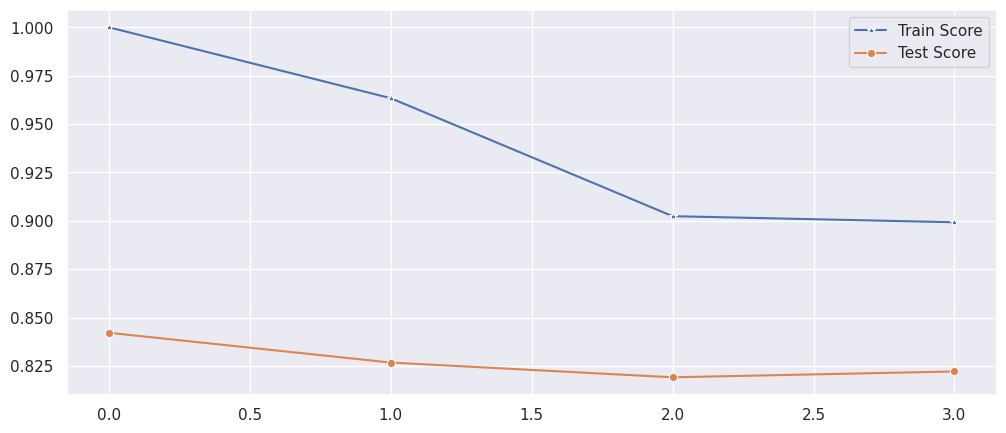

In [ ]:
test_score = []
train_score = []

for i in range(1, 5):
    knn = KNeighborsClassifier(i)
    knn.fit(X_train, y_train)
    train_score.append(knn.score(X_train, y_train))
    test_score.append(knn.score(X_test, y_test))

# max scores
max_train_score = max(train_score)
train_score_ind = [i for i, v in enumerate(train_score) if v == max_train_score]
 
max_test_score = max(test_score)
test_score_ind = [i for i, v in enumerate(test_score) if v == max_test_score]


print(f'Max Train Score : %{max_train_score * 100} - K : {list(map(lambda x: x+1, train_score_ind))}')
print(f'Max Test Score : %{max_test_score * 100} - Best K : {list(map(lambda x: x+1, test_score_ind))}')

# graph

plt.figure(figsize=(12, 5))
p = sns.lineplot(train_score, marker="*", label="Train Score")
p = sns.lineplot(test_score, marker="o", label="Test Score")
plt.show()

In [ ]:
# Fit
knn = KNeighborsClassifier(1)
knn.fit(X_train, y_train)

# prediction
y_prediction_knn = knn.predict(X_test)

In [ ]:
knn_acc=accuracy_score(y_test, y_prediction_knn)
knn_f1=f1_score(y_test, y_prediction_knn)
knn_roc_auc=roc_auc_score(y_test, y_prediction_knn)
print(f'''K Neighbors Classifier Model Evaluation Metrics:
- Accuracy: {(knn_acc * 100):.2f}%
- F1 Score: {(knn_f1 * 100):.2f}%
- ROC AUC Score: {(knn_roc_auc * 100):.2f}%
''')

K Neighbors Classifier Model Evaluation Metrics:
- Accuracy: 84.21%
- F1 Score: 85.42%
- ROC AUC Score: 84.22%



### GaussianNB

In [ ]:
from sklearn.naive_bayes import GaussianNB

In [ ]:
# Train the Random Forest classifier
gnb = GaussianNB()
gnb.fit(X_train, y_train)

# Predict the target values for the test data
y_prediction_gnb = gnb.predict(X_test)

In [ ]:
gnb_acc=accuracy_score(y_test, y_prediction_gnb)
gnb_f1=f1_score(y_test, y_prediction_gnb)
gnb_roc_auc=roc_auc_score(y_test, y_prediction_gnb)
print(f'''GaussianNB Model Evaluation Metrics:
- Accuracy: {(gnb_acc * 100):.2f}%
- F1 Score: {(gnb_f1 * 100):.2f}%
- ROC AUC Score: {(gnb_roc_auc * 100):.2f}%
''')

GaussianNB Model Evaluation Metrics:
- Accuracy: 72.32%
- F1 Score: 74.36%
- ROC AUC Score: 72.33%



## Roc Eğrileri Grafiği

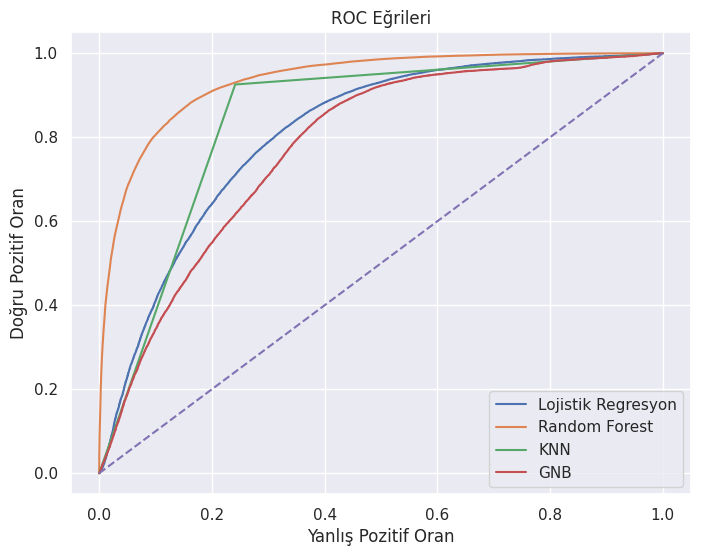

In [ ]:
# lojistik regresyon ROC eğrisi
y_probs_log = logistic_regression.predict_proba(X_test)[:,1]
FPR_log, TPR_log, _ = roc_curve(y_test, y_probs_log)

# rastgele orman ROC eğrisi
y_probs_rf = random_forest.predict_proba(X_test)[:,1]
FPR_rf, TPR_rf, _ = roc_curve(y_test, y_probs_rf)

# KNN ROC eğrisi
y_probs_knn = knn.predict_proba(X_test)[:,1]
FPR_knn, TPR_knn, _ = roc_curve(y_test, y_probs_knn)

# KNN ROC eğrisi
y_probs_gnb = gnb.predict_proba(X_test)[:,1]
FPR_gnb, TPR_gnb, _ = roc_curve(y_test, y_probs_gnb)

# tek bir grafikte üç ROC eğrisi çizimi
fig, ax = plt.subplots(figsize = (8,6))
plt.plot(FPR_log, TPR_log, label='Lojistik Regresyon')
plt.plot(FPR_rf, TPR_rf, label='Random Forest')
plt.plot(FPR_knn, TPR_knn, label='KNN')
plt.plot(FPR_gnb, TPR_gnb, label='GNB')
plt.plot([0,1], [0,1], '--')
plt.xlabel('Yanlış Pozitif Oran')
plt.ylabel('Doğru Pozitif Oran')
plt.title('ROC Eğrileri')
plt.legend()
plt.show()